In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import os
import math
from SoftmaxRegression import * 
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc,confusion_matrix
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot
# Jupyter notebook specific 
from ipywidgets import interactive

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

%matplotlib inline

# Generalization to Logistic Regression:
## Softmax Regression
- $ \text{for } x \in \mathbb{R}^{1\times n} \text{,     } softmax(x) = softmax(\begin{bmatrix}
    x_1  &&
    x_2 &&
    ...  &&
    x_n  
\end{bmatrix}) = \begin{bmatrix}
     \frac{e^{x_1}}{\sum_{j}e^{x_j}}  &&
    \frac{e^{x_2}}{\sum_{j}e^{x_j}}  &&
    ...  &&
    \frac{e^{x_n}}{\sum_{j}e^{x_j}} 
\end{bmatrix} $ 

- $\text{for a matrix } x \in \mathbb{R}^{m \times n} \text{,  $x_{ij}$ maps to the element in the $i^{th}$ row and $j^{th}$ column of $x$, thus we have: }$  $$softmax(x) = softmax\begin{bmatrix}
    x_{11} & x_{12} & x_{13} & \dots  & x_{1n} \\
    x_{21} & x_{22} & x_{23} & \dots  & x_{2n} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    x_{m1} & x_{m2} & x_{m3} & \dots  & x_{mn}
\end{bmatrix} = \begin{bmatrix}
    \frac{e^{x_{11}}}{\sum_{j}e^{x_{1j}}} & \frac{e^{x_{12}}}{\sum_{j}e^{x_{1j}}} & \frac{e^{x_{13}}}{\sum_{j}e^{x_{1j}}} & \dots  & \frac{e^{x_{1n}}}{\sum_{j}e^{x_{1j}}} \\
    \frac{e^{x_{21}}}{\sum_{j}e^{x_{2j}}} & \frac{e^{x_{22}}}{\sum_{j}e^{x_{2j}}} & \frac{e^{x_{23}}}{\sum_{j}e^{x_{2j}}} & \dots  & \frac{e^{x_{2n}}}{\sum_{j}e^{x_{2j}}} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    \frac{e^{x_{m1}}}{\sum_{j}e^{x_{mj}}} & \frac{e^{x_{m2}}}{\sum_{j}e^{x_{mj}}} & \frac{e^{x_{m3}}}{\sum_{j}e^{x_{mj}}} & \dots  & \frac{e^{x_{mn}}}{\sum_{j}e^{x_{mj}}}
\end{bmatrix} = \begin{pmatrix}
    softmax\text{(first row of x)}  \\
    softmax\text{(second row of x)} \\
    \vdots \\
    softmax\text{(last row of x)} \\
\end{pmatrix} $$

In [23]:
# Get the toy Dataset 
def find(name, path): #Helper method for locating files
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)
path =  find('Wisconsin_breast_cancer.csv', "./" )
path

'./Wisconsin_breast_cancer.csv'

In [24]:
# Display the first 5 rows of the dataset
data = pd.read_csv(path, index_col=0)
data.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Target
0,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,0.0
1,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0,0.0
2,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,0.0
3,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0,0.0
4,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0,0.0


In [25]:
# Some Preprocessing 
features = data.columns.values[:-1]
target = data.columns.values[-1]

# 0 -- Benign
# 1 -- Malignant
target_map = {
    'benign':0,
    'malignant':1
}

X, y = data[features], data[target]
y = y.values.reshape((y.shape[0],1))

In [26]:
clf = SoftmaxRegression()
clf.fit(X,y)

 40%|████      | 400/1000 [00:00<00:00, 1997.70it/s]

(9, 2)
Using Gradient Descent


100%|██████████| 1000/1000 [00:00<00:00, 1981.83it/s]


In [27]:
clf.score(X,y)

0.9677891654465594

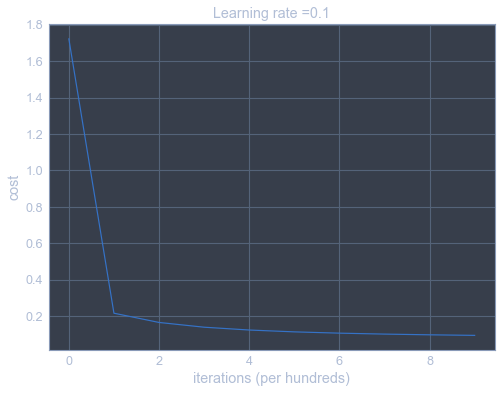

In [28]:
clf.plot_learning_curve()

In [29]:
prob_preds = clf.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, prob_preds)

In [30]:
AUC = auc(fpr,tpr)
AUC

0.9959572543254552

In [31]:
def max_f1(prob_preds, labels):
    """
    Finds the threshold of classification that maximizes the F1 Metric
    
    Arguments: 
    prob_preds -- numpy array of probability scores 
    labels -- ground truth labels
    
    Return:
    cutoff -- Cutoff that maximizes the F1 metric
    max_f1 -- maximal value for the f1 metric
    """
    cutoff = 0
    max_f1 = 0
    for i in prob_preds:
        preds = prob_preds > i
        tmp_score = f1_score(labels, preds)
        if tmp_score > max_f1:
            max_f1 = tmp_score
            cutoff = i
    return cutoff, max_f1

In [32]:
def find_closest_index(cutoff, thresholds):
    """
    Finds the threshold closest to the cutoff. 
    
    Arguments:
    cutoff -- scalar cutoff value
    threshholds -- list of all unique probabilities 
    TODO: implement this using Binary Search 
    
    Return:
    best_index -- index of thresholds that has a value closest to cutoff
    TODO: Implement with binary search. 
    """
    best_index = -1
    min_dist = 9999999
    for i in range(len(thresholds)):
        tmp = abs(cutoff - thresholds[i])
        if tmp < min_dist:
            min_dist = tmp
            best_index = i
    return best_index

In [41]:
cm_cols = ["Predicited Benign", "Predicted Malignant"]
cm_index = ["Benign", "Malignant"]

def plot_roc(cutoff):
    cutoff_index = find_closest_index(cutoff, thresholds)
    print("Closest threshold is", thresholds[cutoff_index])
    print("For threshold of: " ,thresholds[cutoff_index], 'FPR:', fpr[cutoff_index], "TPR:", tpr[cutoff_index])
    fig = plt.figure(figsize=(8,8))
    plt.plot(fpr,tpr)
    plt.title("ROC curve with AUC={}".format(AUC))
    plt.plot([0,1],'r--') 
    plt.scatter(fpr[cutoff_index],tpr[cutoff_index], marker='x',s=200, c='r')
    preds = np.array(prob_preds) >= cutoff
    preds = preds.astype(int)
    cm = confusion_matrix(y, preds)
    f1 = f1_score(y, preds)
    cm_df = pd.DataFrame(cm, index=cm_index, columns=cm_cols)
    print('F1-score',f1)
    print()
    print(cm_df)
    
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive rate")
    
interactive(plot_roc, cutoff=(0.,1.))

interactive(children=(FloatSlider(value=0.5, description='cutoff', max=1.0), Output()), _dom_classes=('widget-…

Closest threshold is 0.2933186294277543
For threshold of:  0.2933186294277543 FPR: 0.02702702702702703 TPR: 0.9916317991631799
F1-score 0.971311475409836

           Predicited Benign  Predicted Malignant
Benign                   432                   12
Malignant                  2                  237


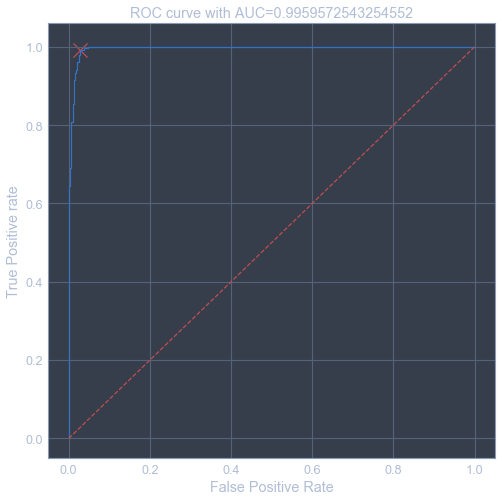

In [42]:
plot_roc(0.293318629427754)